## Recommendation Engine of Active Boomers

This tutorial is developed for rebuilding the recommendation engine with Association rules and Collaborative filtering for [Active Boomers](https://github.com/kartbnb/ActiDiabet) the workout app.

Collaborative filtering, in particular, is a family of algorithms where there are multiple ways to find similar users or items and multiple ways to calculate rating based on ratings of similar users. Depending on the choices you make, you end up with a type of collaborative filtering approach.  This algorithm is one of the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. You can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

Reference: [Build a Recommendation Engine With Collaborative Filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/)


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import random

%matplotlib inline

## Connect to the database 
Using `pymysql` package.

In [2]:
connection = pymysql.connect(
    host='db1.crcnvu3pnfow.ap-southeast-2.rds.amazonaws.com',
    port=int(3306),
    user="admin",
    passwd="********", # confidential!!
    db="b8_db",
    charset='utf8mb4')


## SQL queries
for querying `ratings` data from the db server.

In [3]:
sql_select_Query = pd.read_sql_query("select * from b8_db.popularity_review",connection)

In [4]:
# read sql query into pandas df
rating = pd.DataFrame(sql_select_Query, columns=['review_id','user_id','activity_id','review_rating'])
rating = rating[['activity_id','user_id','review_rating']]
rating.columns = ['item','user','rating']
rating.head()

,item,user,rating
0,5,2,1
1,10,2,-1
2,8,2,1
3,10,6,1
4,8,6,1


We have fetched 105 entries of rating data this time.

In [5]:
rating.shape

(105, 3)

Most ratings are positive given the mean value of the ratings

In [6]:
rating.describe()

,item,user,rating
count,105.000000,105.000000,105.000000
mean,33.485714,49.847619,0.885714
std,23.441053,45.299597,0.466457
min,1.000000,1.000000,-1.000000
25%,8.000000,9.000000,1.000000
50%,39.000000,52.000000,1.000000
75%,50.000000,87.000000,1.000000
max,68.000000,137.000000,1.000000


### Group1: Positive review data

In [7]:
rating_pos = rating[rating['rating']==1]
rating_neg = rating[rating['rating']==-1]

**rating == 1** if a user chooses "I did" after a quick survey after hitting the Done button

In [8]:
rating_pos.head()

,item,user,rating
0,5,2,1
2,8,2,1
3,10,6,1
4,8,6,1
5,8,5,1


### Group2: Negative reviews
**ratting == -1** if they choose "Not sure" after hitting the Done button in the Activity Detail View of the app.

In [9]:
rating_neg.head()

,item,user,rating
1,10,2,-1
6,11,8,-1
7,11,9,-1
8,10,8,-1
9,10,9,-1


# Algorithm 1: Association rules

In [10]:
from mlxtend.frequent_patterns import apriori, association_rules 
from mlxtend.preprocessing import TransactionEncoder

In [11]:
transactions=[]

#Might look at this later 
item_sets = {}

for t,g in rating_pos.groupby('user')['item']:
    transactions.append(g.tolist())
    item_sets[t] = g.tolist()

In [12]:
item_sets

{1: [8, 4, 1, 2, 5, 67, 44, 47],
 2: [5, 8, 44, 47],
 5: [8],
 6: [10, 8],
 7: [16, 39, 67],
 8: [4, 16, 67],
 9: [12,
  8,
  4,
  61,
  2,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  50,
  51,
  52,
  53,
  54,
  55,
  42,
  39,
  38,
  35,
  16],
 50: [3],
 51: [3],
 52: [3, 39],
 53: [50, 39],
 54: [50, 39],
 55: [50, 39],
 56: [50, 39],
 84: [50, 66, 18, 27, 35, 36],
 85: [66, 27],
 86: [66, 50, 18, 27, 35],
 87: [66, 50, 18, 27, 36, 37],
 88: [3],
 89: [3],
 94: [2, 5],
 95: [5],
 96: [2, 5],
 97: [2, 5],
 100: [44, 67],
 101: [67],
 102: [44, 67],
 103: [44, 67],
 134: [44, 67, 2],
 135: [4],
 136: [67, 45, 44],
 137: [45]}

In [13]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
ap = pd.DataFrame(te_ary, columns=te.columns_)

In [14]:
ap

,1,2,3,4,5,8,10,12,16,18,...,54,55,61,62,63,64,65,66,67,68
0,True,True,False,True,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
5,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
6,False,True,False,True,False,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True
7,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


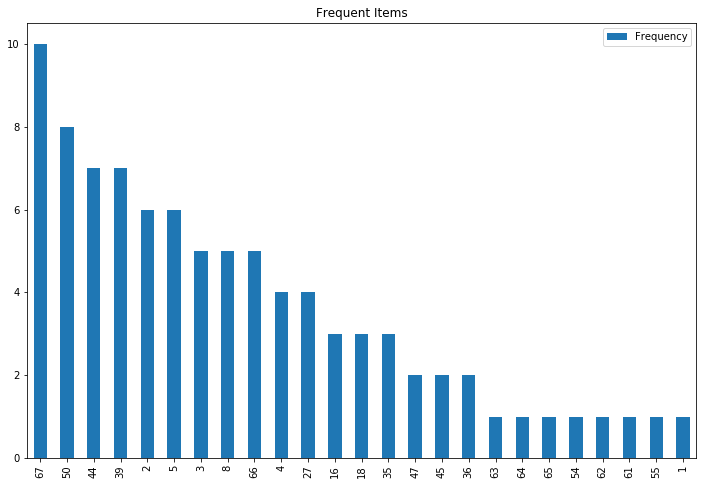

In [15]:
#Quick look at the top 25 items
%matplotlib inline
ap.sum().to_frame('Frequency').sort_values('Frequency',ascending=False)[:25].plot(kind='bar',
                                                                                  figsize=(12,8),
                                                                                  title="Frequent Items")
plt.show()

In [16]:
# Building the model 
frq_items = apriori(ap, min_support = 0.05, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules.head()) 

    antecedents consequents  antecedent support  consequent support  support  \
108      (8, 5)        (47)              0.0625              0.0625   0.0625   
113        (47)      (8, 5)              0.0625              0.0625   0.0625   
114     (44, 5)        (47)              0.0625              0.0625   0.0625   
119        (47)     (44, 5)              0.0625              0.0625   0.0625   
120     (8, 44)        (47)              0.0625              0.0625   0.0625   

     confidence  lift  leverage  conviction  
108         1.0  16.0  0.058594         inf  
113         1.0  16.0  0.058594         inf  
114         1.0  16.0  0.058594         inf  
119         1.0  16.0  0.058594         inf  
120         1.0  16.0  0.058594         inf  


In [17]:
rules[rules['confidence'] > 0.99].head(30)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
108,"(8, 5)",(47),0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
113,(47),"(8, 5)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
114,"(44, 5)",(47),0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
119,(47),"(44, 5)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
120,"(8, 44)",(47),0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
125,(47),"(8, 44)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
233,"(8, 67)","(2, 4)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
236,"(2, 4)","(8, 67)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
242,"(8, 44, 5)",(47),0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf
246,"(8, 44)","(5, 47)",0.06250,0.06250,0.06250,1.0,16.000000,0.058594,inf


# Algorithm 2: Collaborative Filtering

Item names associated with the id's

In [18]:
sql_select_Query = pd.read_sql_query("select activity_id, activity_name from b8_db.physical_activity",connection)
item = pd.DataFrame(sql_select_Query, columns=['activity_id',
                                             'activity_name'])
item.columns = ['item_id','item_name']
item.head(10)

,item_id,item_name
0,1,Fast walk
1,2,Easy dance exercises
2,3,ABS HIIT workout
3,4,Cycling
4,5,Pool workout
5,6,Water aerobic
6,7,Badminton
7,8,Tennis
8,9,Shoulder rotation
9,10,Shoulder raise


Rating data entered by individual users

In [19]:
rating

,item,user,rating
0,5,2,1
1,10,2,-1
2,8,2,1
3,10,6,1
4,8,6,1
...,...,...,...
100,39,56,1
101,39,55,1
102,39,54,1
103,39,53,1


## Collaborative Filtering Algorithm
The model we are going to build is rather simple, which only takes three variables:
1. item id
2. user id
3. rating


To build a system that can automatically recommend items to users based on the preferences of other users, the first step is to find similar users or items. The second step is to predict the ratings of the items that are not yet rated by a user.

One important thing to keep in mind is that in an approach based purely on collaborative filtering, the similarity is not calculated using factors like the age of users, genre of the movie, or any other data about users or items. It is calculated only on the basis of the rating (explicit or implicit) a user gives to an item. For example, two users can be considered similar if they give the same ratings to ten movies despite there being a big difference in their age.

In [20]:
import pandas as pd
from surprise import Dataset
from surprise import Reader

In [21]:
reader = Reader(rating_scale=(-1, 1))
data = Dataset.load_from_df(rating[["user", "item", "rating"]], reader)

There are two approaches to do collaborative filtering:
1. User based
2. Item based

In fact, item-based collaborative filtering was developed by Amazon. In a system where there are more users than items, item-based filtering is faster and more stable than user-based. It is effective because usually, the average rating received by an item doesn’t change as quickly as the average rating given by a user to different items. It’s also known to perform better than the user-based approach when the ratings matrix is sparse.

Since number of items in our app server was currently less than 100 while the number of users > 100, **an item based collaborative filtering** seems more suitable for us here, so we set `user_based` to **False** in the below parameters.

### K-Nearest Neighbours
There are quite a few libraries and toolkits in Python that provide implementations of various algorithms that you can use to build a recommender. The algorithm Centered k-NN we are going to use here is available in `Surprise` as `KNNWithMeans`.

In [22]:
# recommender.py
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [23]:
trainingSet = data.build_full_trainset()
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Example: making predictions for user 1-3 using the trained model

In [24]:
users = [1,2,3]
start = 1
end = 11

for user in users:
    print(f"\nPredicted rating on item{start}-{end-1} for user{user}" )

    for i in range(start,end):
        prediction = algo.predict(user, i)
        print("item",i,":",prediction.est)


Predicted rating on item1-10 for user1
item 1 : 1
item 2 : 1
item 3 : 1
item 4 : 1
item 5 : 1
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 1
item 9 : 0.8857142857142857
item 10 : -0.5

Predicted rating on item1-10 for user2
item 1 : 1
item 2 : 1
item 3 : 1
item 4 : 1
item 5 : 1
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 1
item 9 : 0.8857142857142857
item 10 : -1

Predicted rating on item1-10 for user3
item 1 : 0.8857142857142857
item 2 : 0.8857142857142857
item 3 : 0.8857142857142857
item 4 : 0.8857142857142857
item 5 : 0.8857142857142857
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 0.8857142857142857
item 9 : 0.8857142857142857
item 10 : 0.8857142857142857


## From predicted ratings to actual recommendations
The output of the model is a predicted rating (ranging from -1 to 1). But, what are we goint to do with these predictions?

Since our user/item dataset is currently relatively small in size, we are having higher chance of overfitting here. That's why we are going to downplay the effect of these predictions a little, not ruling out the possibility of items with negative predictions being recommended completely. 

So now, based on the predictions, we are going to manually generate a weight for each item. And then we are going to randomly select an item from such weighted list as a recommendation for a given user. This way, even items with low predicted ratings still get to be recommeded (even though the probability of that is also ralatively lower given the lower weights).

In [25]:
def generate_weights(user,item_list,algo):
    """generates a list of items based on their weights"""
    
    # generates predictions
    def rating_pred(user,item_list,algo):
        pred = {}
        for i in item_list:
            prediction = algo.predict(user, i)
            pred[i] = prediction.est
        return pred
    
    # generates weights 
    weighted_list = []
    pred = rating_pred(3,item_list,algo)
    
    for i in pred.keys():
        if pred[i] <0: # if the predicted rating is negative
            weighted_list += [i]
        elif pred[i] <0.9: # if the predicted rating < 0.9
            weighted_list += 2 * [i]
        else: # if pred == 1
            weighted_list += 3 * [i]
    return weighted_list
    

In [26]:
len(item.item_id)

68

In [27]:
weighted_l = generate_weights(3,item.item_id,algo)
len(weighted_l)

136

## Recommendations generated from the weighted list for user 3

### Simulation: Runing 1000 times of recommendations based on the weighted list for user3

In [28]:
freq_D = {}
for i in range(1000):
    item = random.choice(weighted_l)
    if item not in freq_D:
        freq_D[item] = 1
    else:
        freq_D[item] +=1
 
freq_df = pd.DataFrame(freq_D.items(),columns=['item','frequency'])

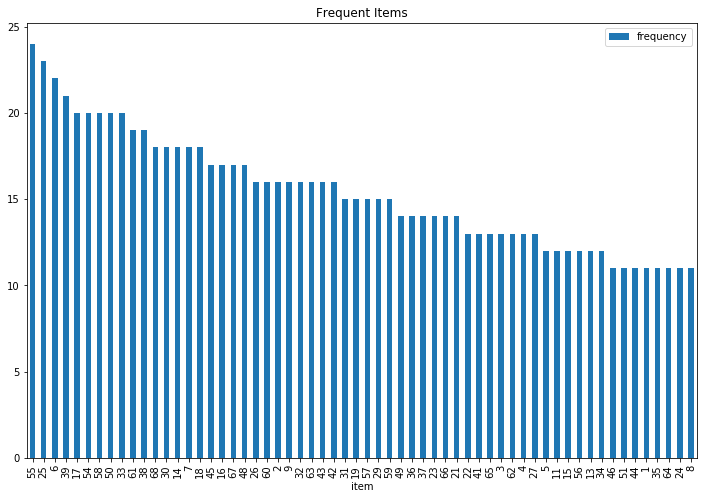

In [29]:
freq_df.sort_values('frequency',ascending=False).set_index('item')[:60].plot(kind='bar',figsize=(12,8),
                                                           title="Frequent Items")
plt.show()

The frequency was indeed not evenly distributed because of the different weights we gave to each item based on the predicted ratings of the algorithm.

### Tuning the Algorithm Parameters

In [30]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import GridSearchCV

data = Dataset.load_builtin("ml-100k")
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi